In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
import seaborn as sns
print(tf.__version__)

2.11.0


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [34]:
#Load dataset and insert column names, remove the semicolon
#Data preprocessing

column_names= ["user_id", "activity", "timestamp", "axis_x", "axis_y", "axis_z"]
data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, comment=";", error_bad_lines=False)

C:\Users\procns\AppData\Local\Temp\ipykernel_7420\608240631.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, comment=";", error_bad_lines=False)
Skipping line 832904: expected 6 fields, saw 7
Skipping line 832905: expected 6 fields, saw 7
Skipping line 832906: expected 6 fields, saw 7
Skipping line 832907: expected 6 fields, saw 7
Skipping line 832908: expected 6 fields, saw 7
Skipping line 832909: expected 6 fields, saw 7
Skipping line 832910: expected 6 fields, saw 7
Skipping line 832911: expected 6 fields, saw 7
Skipping line 832912: expected 6 fields, saw 7
Skipping line 832913: expected 6 fields, saw 7
Skipping line 832914: expected 6 fields, saw 7
Skipping line 832915: expected 6 fields, saw 7
Skipping line 832916: expected 6 fields, saw 7
Skipping line 83

In [13]:
data = data.dropna()

In [14]:
print('Total rows : ', len(data))
data.head()

Total rows :  1086471


,user_id,activity,timestamp,axis_x,axis_y,axis_z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [15]:
data['user_id'].value_counts()

20    56632
19    45383
31    44282
8     41188
29    38245
14    38192
13    37093
34    35947
32    35506
3     35161
27    34958
10    34883
18    32811
12    32641
26    32578
36    32261
11    31658
7     30967
1     29978
6     29704
33    29453
5     28510
15    28154
24    25736
23    25673
30    25335
21    23703
2     23525
35    22394
22    22310
17    22020
28    21358
16    20470
25    13468
9     12923
4     11371
Name: user_id, dtype: int64

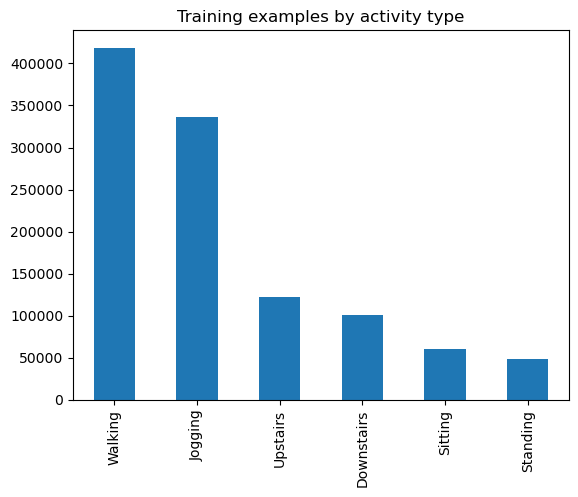

In [16]:
data['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

<Axes: xlabel='activity', ylabel='count'>

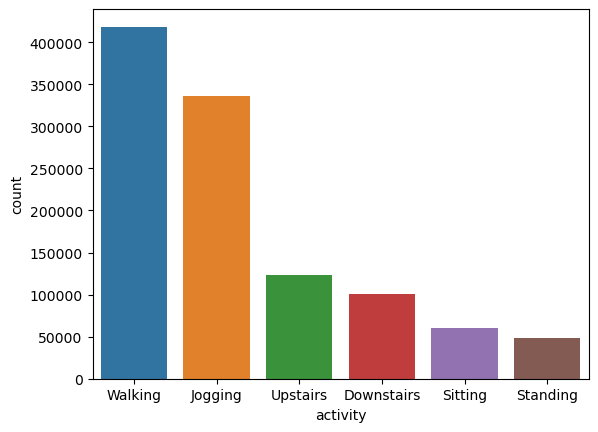

In [17]:
sns.countplot(x = "activity", data = data, order = data.activity.value_counts().index)

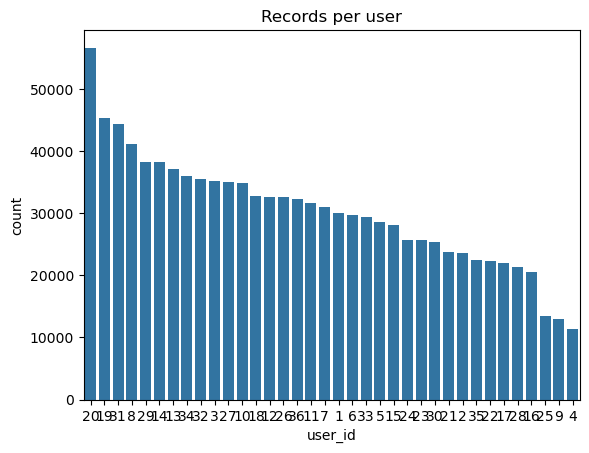

In [18]:
sns.countplot(x = "user_id", data = data, palette = [sns.color_palette()[0]],
              order = data.user_id.value_counts().index)
plt.title("Records per user");

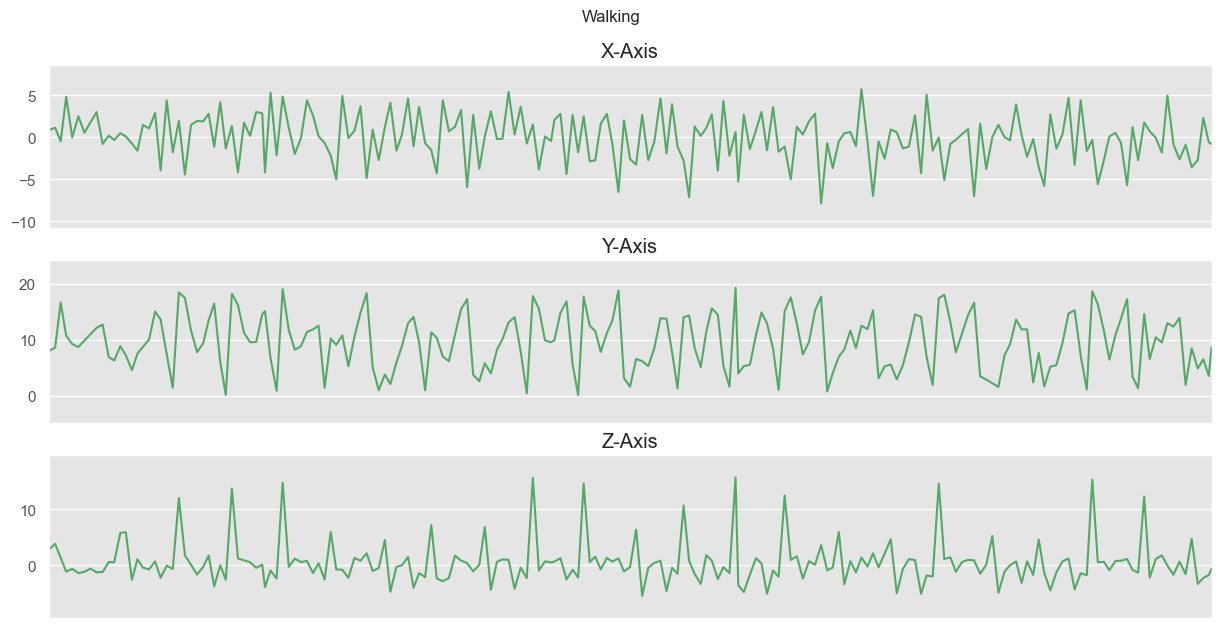

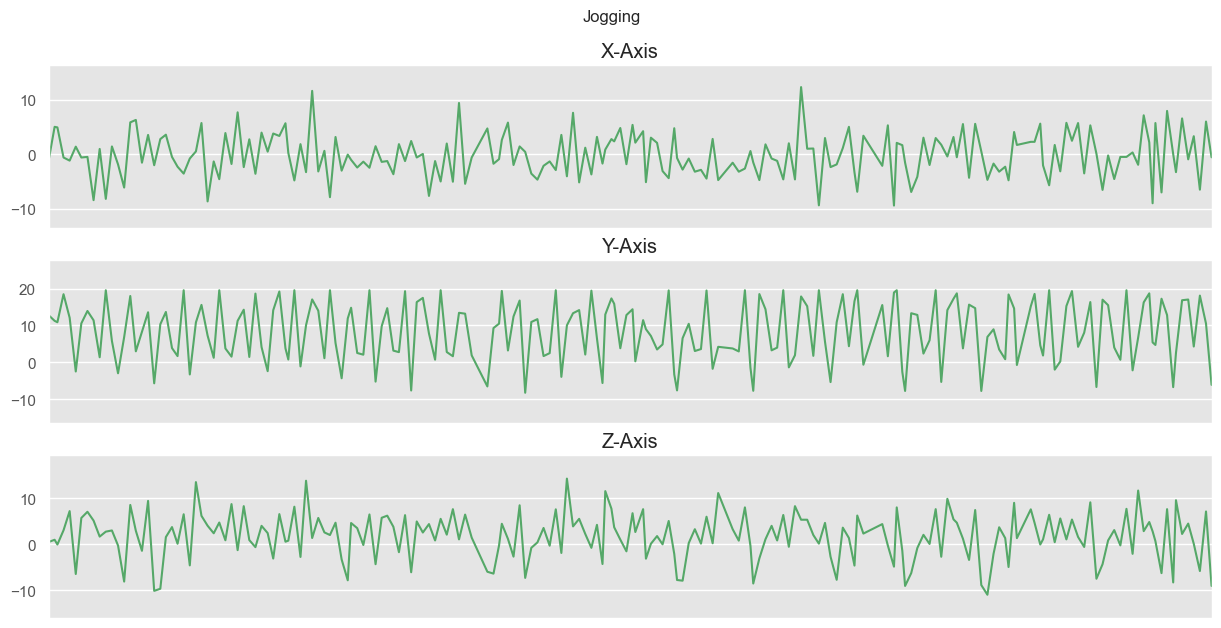

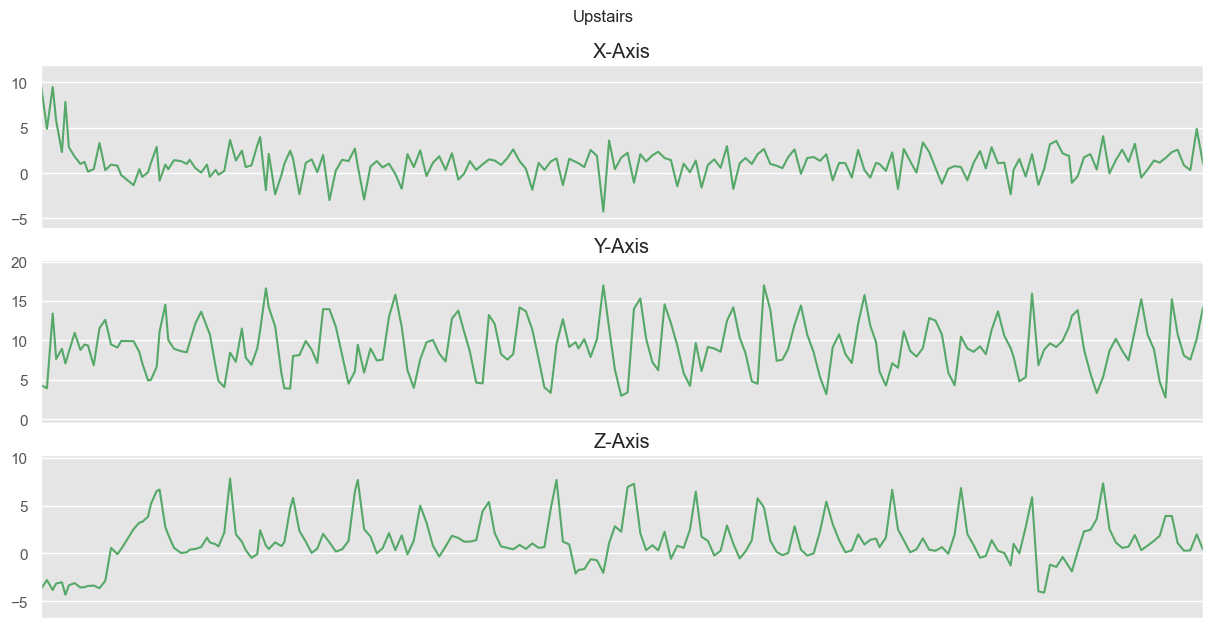

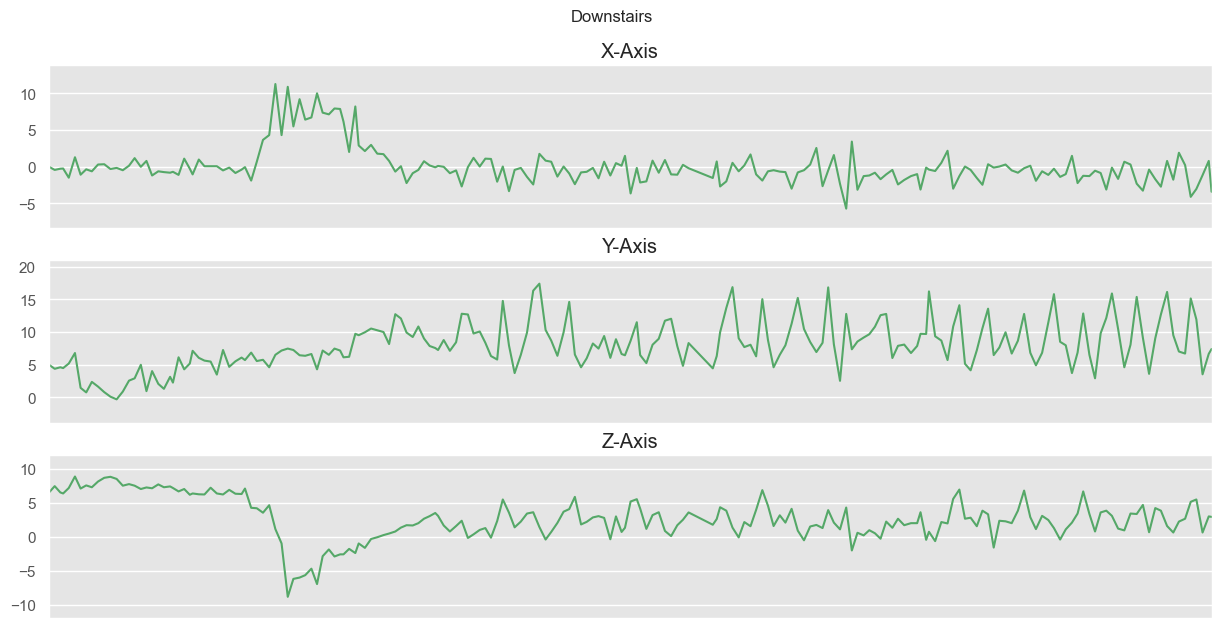

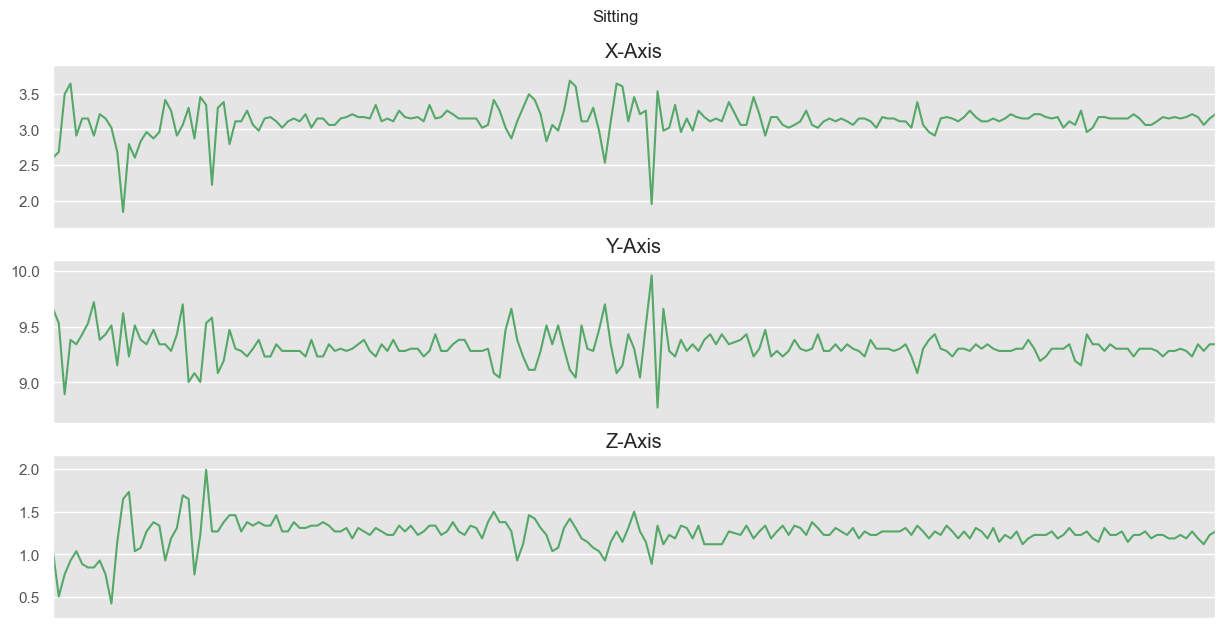

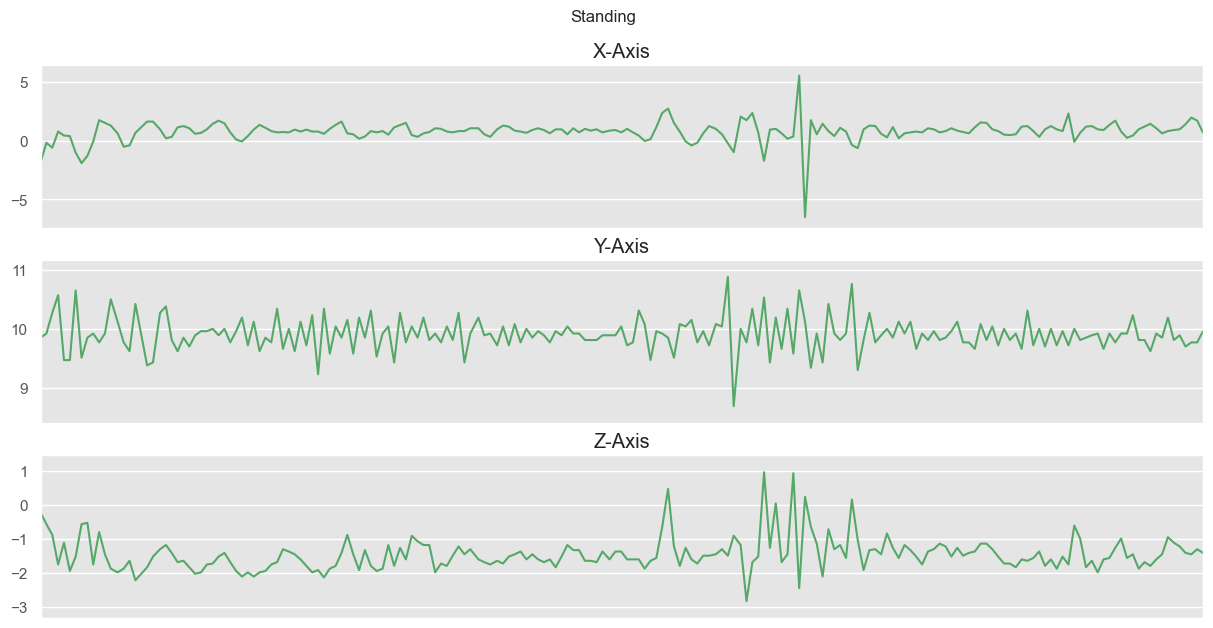

In [37]:
activities = data['activity'].value_counts().index
activities

def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['timestamp'], data['axis_x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['axis_y'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['axis_z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

Fs = 20
for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [21]:
import seaborn as sns

pd.options.display.float_format = "{:.1f}".format # Set some standard parameters upfront
sns.set() # Default seaborn look and feel
plt.style.use("ggplot")
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
# The number of steps within one time segment
TIME_PERIODS = 128
# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS, then there is
# no overlap between the segments
STEP_DISTANCE = 64

In [22]:
def read_data(file_path):
    column_names = ["user-id", "activity", "timestamp", "x-axis", "y-axis", "z-axis"]
    df = pd.read_csv(file_path, header = None, names = column_names, error_bad_lines=False)
    # Last column has a ";" character which must be removed ...
    df["z-axis"].replace(regex = True, inplace = True, to_replace = r';', value = r'')
    # ... and then this column must be transformed to float explicitly
    #df["z-axis"] = df["z-axis"].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)
    return df

def convert_to_float(x):
    try:
        return np.float(x)
    except:
        return np.nan
    
def show_basic_dataframe_info(dataframe):
    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')

C:\Users\procns\AppData\Local\Temp\ipykernel_7420\3277801643.py:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv(file_path, header = None, names = column_names, error_bad_lines=False)
Skipping line 134634: expected 6 fields, saw 11
Skipping line 197687: expected 6 fields, saw 11

Skipping line 273261: expected 6 fields, saw 11

Skipping line 711485: expected 6 fields, saw 11

Skipping line 832904: expected 6 fields, saw 7
Skipping line 832905: expected 6 fields, saw 7
Skipping line 832906: expected 6 fields, saw 7
Skipping line 832907: expected 6 fields, saw 7
Skipping line 832908: expected 6 fields, saw 7
Skipping line 832909: expected 6 fields, saw 7
Skipping line 832910: expected 6 fields, saw 7
Skipping line 832911: expected 6 fields, saw 7
Skipping line 832912: expected 6 fields, saw 7
Skipping line 832913: expected 6 fields, saw 7
Skipping line 832914: expected 6 fields

In [23]:
show_basic_dataframe_info(data)
data.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1086471



,user_id,activity,timestamp,axis_x,axis_y,axis_z
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086467 entries, 0 to 1086467
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1086467 non-null  int64  
 1   activity   1086467 non-null  object 
 2   timestamp  1086467 non-null  int64  
 3   x-axis     1086467 non-null  float64
 4   y-axis     1086467 non-null  float64
 5   z-axis     1086467 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 58.0+ MB


In [25]:
df.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.50395286
1,33,Jogging,49106062271000,5.0,11.3,0.95342433
2,33,Jogging,49106112167000,4.9,10.9,-0.08172209
3,33,Jogging,49106222305000,-0.6,18.5,3.0237172
4,33,Jogging,49106332290000,-1.2,12.1,7.205164


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086471 entries, 0 to 1086471
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1086471 non-null  int64  
 1   activity   1086471 non-null  object 
 2   timestamp  1086471 non-null  int64  
 3   axis_x     1086471 non-null  float64
 4   axis_y     1086471 non-null  float64
 5   axis_z     1086471 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


In [27]:
data.tail()

,user_id,activity,timestamp,axis_x,axis_y,axis_z
1086467,19,Sitting,131623331483000,9.0,-1.6,1.7
1086468,19,Sitting,131623371431000,9.0,-1.5,1.7
1086469,19,Sitting,131623411592000,9.1,-1.4,1.7
1086470,19,Sitting,131623491487000,9.0,-1.5,1.7
1086471,19,Sitting,131623531465000,8.9,-1.3,1.6


In [28]:
from sklearn import preprocessing

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
data[LABEL] = le.fit_transform(data["activity"].values.ravel())

In [29]:
# Differentiate between test set and training set
data_test = data[data["user_id"] > 28]
data_train = data[data["user_id"] <= 28]

In [30]:
data.head()

,user_id,activity,timestamp,axis_x,axis_y,axis_z,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


In [31]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
data_train["axis_x"] = data_train["axis_x"] / data_train["axis_x"].max()
data_train["axis_y"] = data_train["axis_y"] / data_train["axis_y"].max()
data_train["axis_z"] = data_train["axis_z"] / data_train["axis_z"].max()
# Round numbers
df_train = data_train.round({"axis_x": 4, "axis_y": 4, "axis_z": 4})


In [32]:
data_train[(data_train['user_id'] == 17) & (data_train['activity'] == 'Jogging')]

,user_id,activity,timestamp,axis_x,axis_y,axis_z,ActivityEncoded
11466,17,Jogging,58231492296000,-0.0,0.5,-0.0,1
11467,17,Jogging,58231592272000,0.0,0.5,-0.1,1
11468,17,Jogging,58231692278000,0.1,0.5,-0.1,1
11469,17,Jogging,58231802294000,0.1,0.5,-0.1,1
11470,17,Jogging,58231912340000,0.0,0.5,-0.1,1
...,...,...,...,...,...,...,...
14348,17,Jogging,58547962267000,0.1,0.6,0.2,1
14349,17,Jogging,58548012438000,0.4,0.6,0.0,1
14350,17,Jogging,58548122454000,0.3,0.7,-0.0,1
14351,17,Jogging,58548232378000,0.0,0.3,-0.1,1


In [52]:
data_train.shape , TIME_PERIODS, STEP_DISTANCE

((823048, 7), 128, 64)

In [84]:
import numpy as np
from scipy import stats
    
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df["axis_x"].values[i: i + time_steps]
        ys = df["axis_y"].values[i: i + time_steps]
        zs = df["axis_z"].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        #stats.mode는 가장 빈도가 높은 값(같으면 앞의 값) 추출
        segments.append([xs, ys, zs])
        labels.append(label)
    print(len(segments))
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    print('reshaped_segments shape : ', reshaped_segments.shape)
    labels = np.asarray(labels)
    print('labels shape :', labels.shape)
    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(data_train, TIME_PERIODS, STEP_DISTANCE, LABEL)

C:\Users\procns\AppData\Local\Temp\ipykernel_11516\1968610926.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)


In [85]:
x_train.shape, y_train.shape

((12859, 128, 3), (12859,))

In [86]:
print("x_train shape: ", x_train.shape)
print(x_train.shape[0], 'training samples')
print("y_train shape: ", y_train.shape)

x_train shape:  (12859, 128, 3)
12859 training samples
y_train shape:  (12859,)


In [87]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [88]:
num_time_periods, num_sensors, num_classes

(128, 3, 6)

In [89]:
x_train = x_train.astype("float32")
y_train = y_train.astype("float32")

In [90]:
y_train =  y_train.reshape(-1,1)

In [91]:
y_train

array([[5.],
       [5.],
       [5.],
       ...,
       [2.],
       [2.],
       [2.]], dtype=float32)

from scipy import stats

def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(stats.mode(labels)[0][0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 200
STEP = 40

X_train, y_train = create_dataset(df_train[["x-axis", "y-axis", "z-axis"]], df_train.activity, TIME_STEPS,
                                  STEP)
X_test, y_test = create_dataset(df_test[["x-axis", "y-axis", "z-axis"]], df_test.activity, TIME_STEPS, STEP)

print(X_train.shape, y_train.shape)

In [92]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train = enc.transform(y_train)
#y_test = enc.transform(y_test)

print(x_train.shape, y_train.shape)

(12859, 128, 3) (12859, 6)


C:\Users\procns\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [93]:
#Epoch 500

verbose,epochs,batch_size=1,10,32 

n_timesteps,n_features,n_outputs=x_train.shape[1],x_train.shape[2],y_train.shape[1]

In [94]:
#CNN MODEL
import keras
inputs=keras.Input(shape=(n_timesteps,n_features))


conv_1=tf.keras.layers.Conv1D(filters=64,kernel_size=5,strides=2,activation='relu')(inputs)
maxpool_1=tf.keras.layers.MaxPooling1D(pool_size=2,strides=2)(conv_1)

conv_2=tf.keras.layers.Conv1D(filters=96,kernel_size=3,strides=1,activation='relu')(maxpool_1)
maxpool_2=tf.keras.layers.MaxPooling1D(pool_size=2,strides=1)(conv_2)

conv_3=tf.keras.layers.Conv1D(filters=32,kernel_size=3,strides=1,activation='relu')(maxpool_2)
avg_pooling=tf.keras.layers.GlobalAveragePooling1D()(conv_3)
batch_norm=tf.keras.layers.BatchNormalization()(avg_pooling)

output=tf.keras.layers.Dense(n_outputs,activation='softmax')(batch_norm)
model=tf.keras.Model(inputs=inputs,outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 3)]          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 62, 64)            1024      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 31, 64)           0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 29, 96)            18528     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 28, 96)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 26, 32)            9248

In [95]:
import pydot
from tensorflow.keras.utils import plot_model 

plot_model(model, show_shapes=True, to_file='CNN_Model.png')
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [96]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from scipy import ndimage
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D,Conv2D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import BatchNormalization,ReLU,GlobalAveragePooling1D,MaxPooling1D,LSTM,TimeDistributed,GlobalAveragePooling2D
#from keras.utils import to_categorical
from tensorflow.keras.models import save_model,load_model
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model,save_model,load_model
from keras.layers import Input
from keras.layers import Concatenate


from datetime import datetime
from packaging import version

import os
import tempfile
import os
import tensorflow as tf
from tensorflow import expand_dims
from tensorflow import keras

In [97]:
logs = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logs,
                                                 histogram_freq = 1,
                                                 )

history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose,callbacks=[tboard_callback])
model.summary()

Epoch 1/10
402/402 [==============================] - 5s 9ms/step - loss: 0.5078 - accuracy: 0.8287
Epoch 2/10
402/402 [==============================] - 4s 9ms/step - loss: 0.2412 - accuracy: 0.9227
Epoch 3/10
402/402 [==============================] - 4s 9ms/step - loss: 0.1832 - accuracy: 0.9398
Epoch 4/10
402/402 [==============================] - 4s 9ms/step - loss: 0.1577 - accuracy: 0.9480
Epoch 5/10
402/402 [==============================] - 4s 9ms/step - loss: 0.1294 - accuracy: 0.9566
Epoch 6/10
402/402 [==============================] - 4s 9ms/step - loss: 0.1239 - accuracy: 0.9567
Epoch 7/10
402/402 [==============================] - 4s 9ms/step - loss: 0.1077 - accuracy: 0.9644
Epoch 8/10
402/402 [==============================] - 4s 9ms/step - loss: 0.0953 - accuracy: 0.9680
Epoch 9/10
402/402 [==============================] - 4s 10ms/step - loss: 0.0797 - accuracy: 0.9730
Epoch 10/10
402/402 [==============================] - 4s 9ms/step - loss: 0.0799 - accuracy: 0.974

In [ ]:
%time
print(X_test.shape,y_test.shape)
base_loss,base_accuracy=model.evaluate(X_test,y_test,batch_size=batch_size,verbose=1)

cnn_file='CNN_Model.h5'
  
tf.keras.models.save_model(model, cnn_file, include_optimizer=False)
print('model saved at ', cnn_file)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

# ---------------------------------------------------------

In [47]:
file = open('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [4]:
processedList

[['33', 'Jogging', '49105962326000', '-0.6946377', '12.680544', '0.50395286'],
 ['33', 'Jogging', '49106062271000', '5.012288', '11.264028', '0.95342433'],
 ['33', 'Jogging', '49106112167000', '4.903325', '10.882658', '-0.08172209'],
 ['33', 'Jogging', '49106222305000', '-0.61291564', '18.496431', '3.0237172'],
 ['33', 'Jogging', '49106332290000', '-1.1849703', '12.108489', '7.205164'],
 ['33', 'Jogging', '49106442306000', '1.3756552', '-2.4925237', '-6.510526'],
 ['33', 'Jogging', '49106542312000', '-0.61291564', '10.56939', '5.706926'],
 ['33', 'Jogging', '49106652389000', '-0.50395286', '13.947236', '7.0553403'],
 ['33', 'Jogging', '49106762313000', '-8.430995', '11.413852', '5.134871'],
 ['33', 'Jogging', '49106872299000', '0.95342433', '1.3756552', '1.6480621'],
 ['33', 'Jogging', '49106982315000', '-8.19945', '19.57244', '2.7240696'],
 ['33', 'Jogging', '49107092330000', '1.4165162', '5.7886477', '2.982856'],
 ['33', 'Jogging', '49107202316000', '-1.879608', '-2.982856', '-0.2996

In [5]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [6]:
data = pd.DataFrame(data = processedList, columns = columns)
data.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [7]:
# Data Balance
data['x'] = data['x'].astype('float')
data['y'] = data['y'].astype('float')
data['z'] = data['z'].astype('float')

data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


In [8]:
data['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343416 entries, 0 to 343415
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user      343416 non-null  object 
 1   activity  343416 non-null  object 
 2   time      343416 non-null  object 
 3   x         343416 non-null  float64
 4   y         343416 non-null  float64
 5   z         343416 non-null  float64
dtypes: float64(3), object(3)
memory usage: 15.7+ MB


In [40]:
Fs = 20
activities = data['activity'].value_counts().index
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object')

In [ ]:
data['activity'].value_counts()

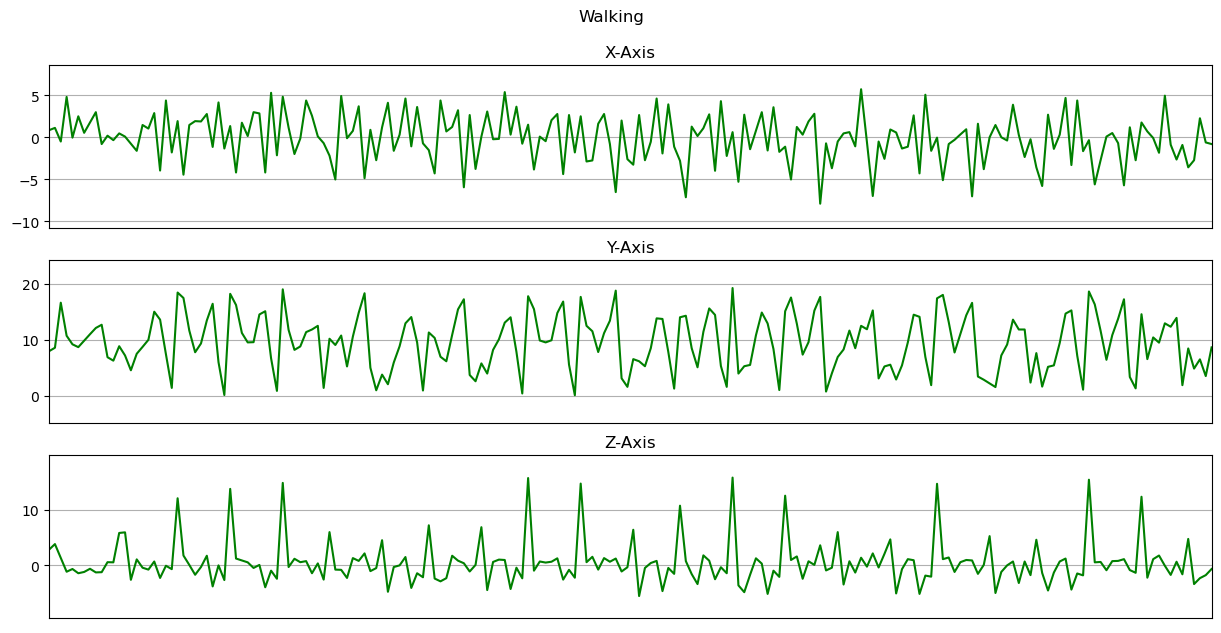

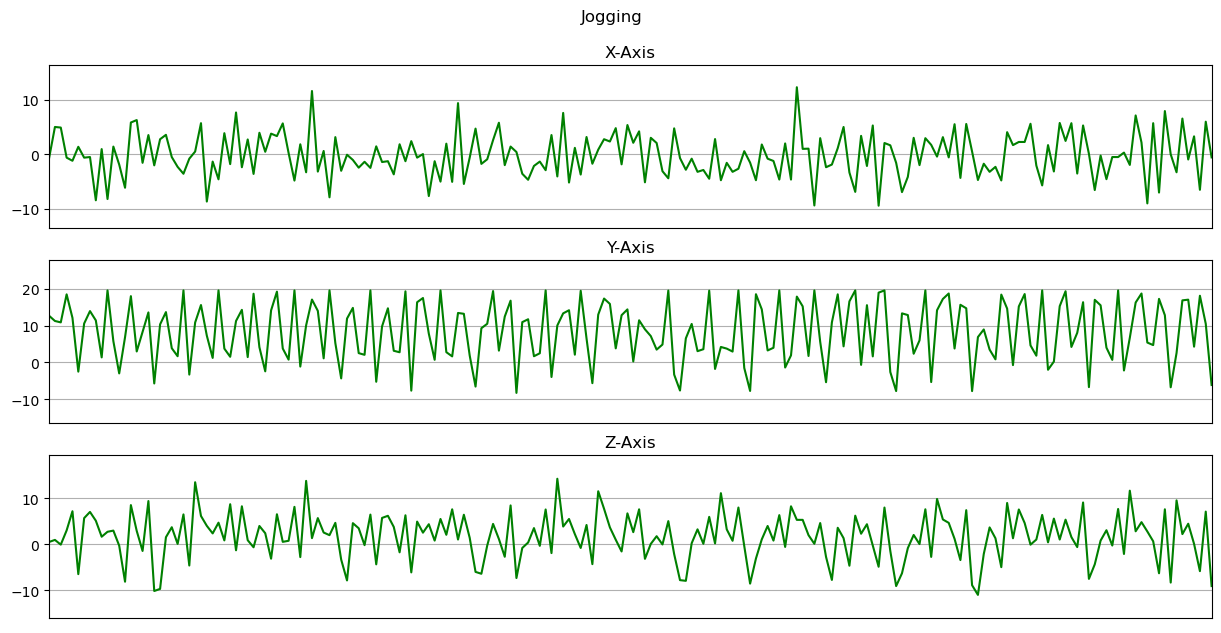

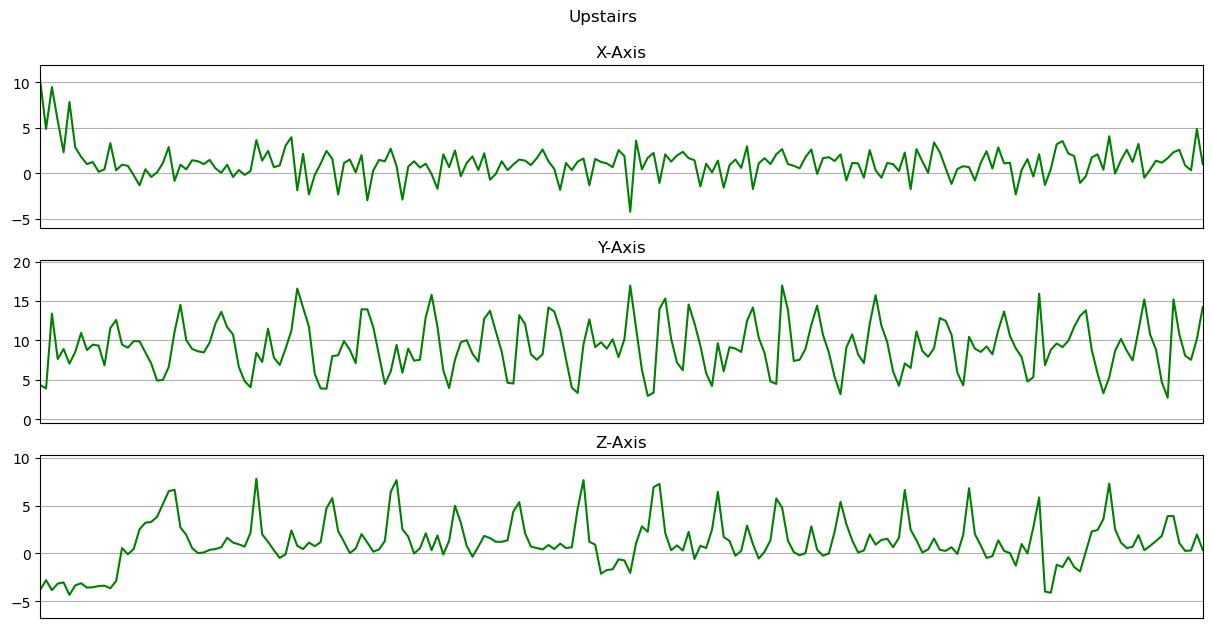

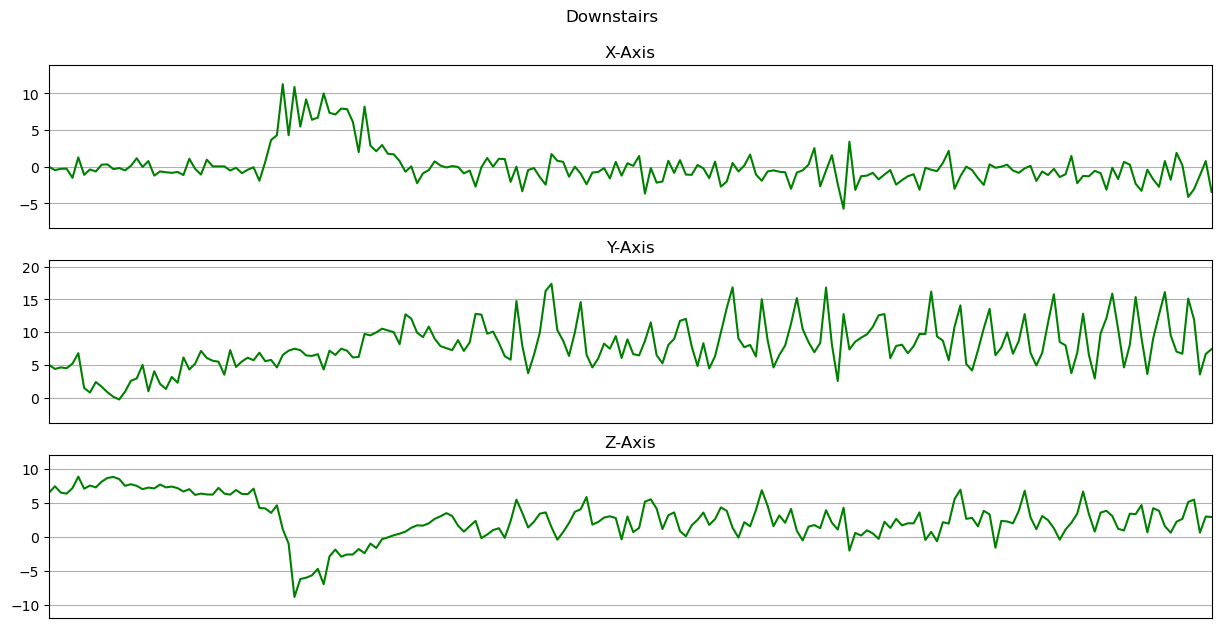

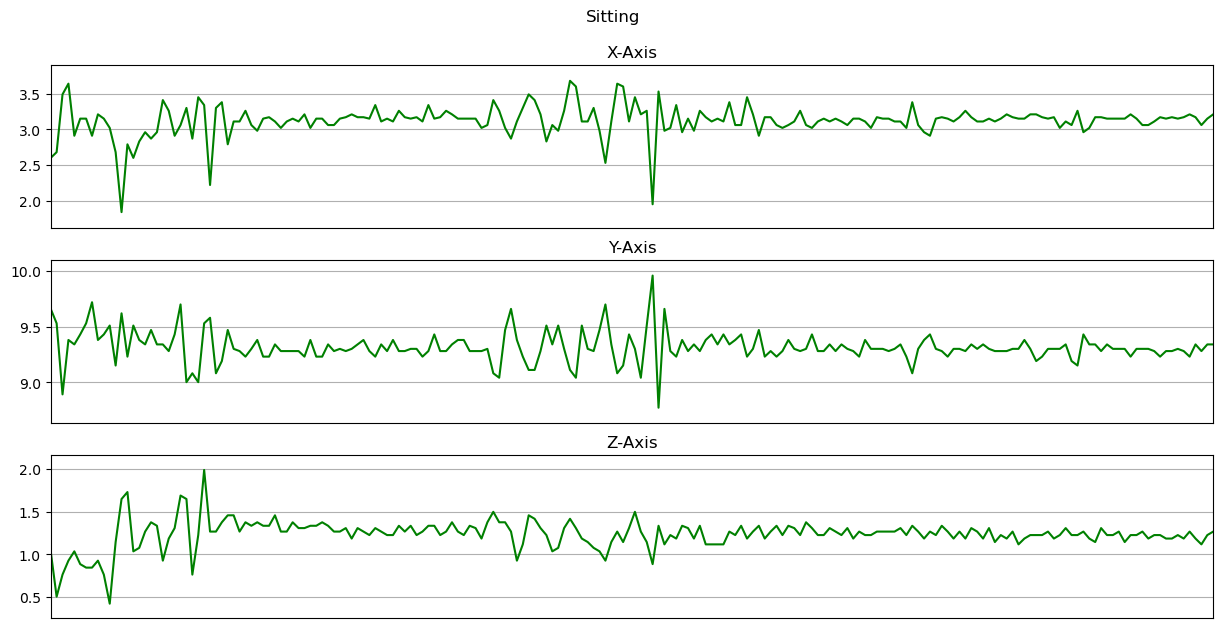

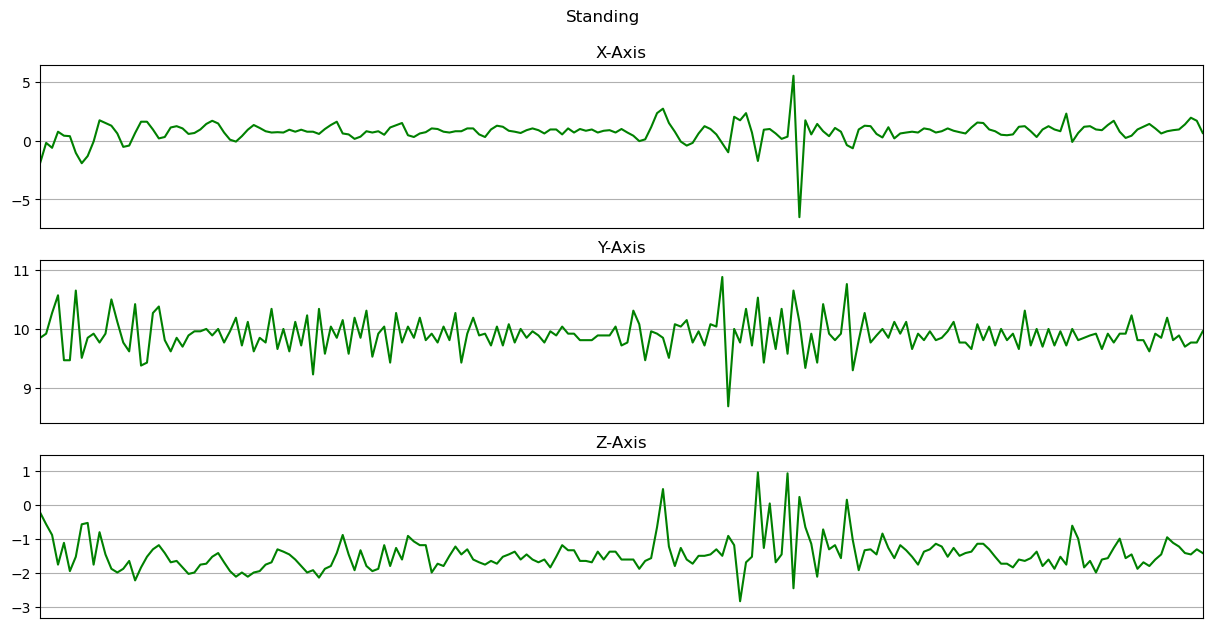

In [41]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['time'], data['x'], 'X-Axis')
    plot_axis(ax1, data['time'], data['y'], 'Y-Axis')
    plot_axis(ax2, data['time'], data['z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

Fs = 20
for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)
     

In [12]:
df = data.drop(['user', 'time'], axis = 1).copy()
df.head()

,activity,x,y,z
0,Jogging,-0.694638,12.680544,0.503953
1,Jogging,5.012288,11.264028,0.953424
2,Jogging,4.903325,10.882658,-0.081722
3,Jogging,-0.612916,18.496431,3.023717
4,Jogging,-1.184970,12.108489,7.205164


In [13]:
df['activity'].value_counts()

Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: activity, dtype: int64

In [14]:
Walking = df[df['activity']=='Walking'].head(3555).copy()
Jogging = df[df['activity']=='Jogging'].head(3555).copy()
Upstairs = df[df['activity']=='Upstairs'].head(3555).copy()
Downstairs = df[df['activity']=='Downstairs'].head(3555).copy()
Sitting = df[df['activity']=='Sitting'].head(3555).copy()
Standing = df[df['activity']=='Standing'].copy()
     

balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])
balanced_data.shape

C:\Users\procns\AppData\Local\Temp\ipykernel_9448\3359610400.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_data = balanced_data.append([Walking, Jogging, Upstairs, Downstairs, Sitting, Standing])


(21330, 4)

In [15]:
balanced_data['activity'].value_counts()

Walking       3555
Jogging       3555
Upstairs      3555
Downstairs    3555
Sitting       3555
Standing      3555
Name: activity, dtype: int64

In [16]:
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
balanced_data['label'] = label.fit_transform(balanced_data['activity'])
balanced_data.head()

,activity,x,y,z,label
597,Walking,0.844462,8.008764,2.792171,5
598,Walking,1.116869,8.621680,3.786457,5
599,Walking,-0.503953,16.657684,1.307553,5
600,Walking,4.794363,10.760075,-1.184970,5
601,Walking,-0.040861,9.234595,-0.694638,5


In [17]:
label.classes_

array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
       'Walking'], dtype=object)

In [18]:
# Standardizing data
X = balanced_data[['x', 'y', 'z']]
y = balanced_data['label']

In [19]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,0.000503,-0.099190,0.337933,5
1,0.073590,0.020386,0.633446,5
2,-0.361275,1.588160,-0.103312,5
3,1.060258,0.437573,-0.844119,5
4,-0.237028,0.139962,-0.698386,5
...,...,...,...,...
21325,-0.470217,0.178084,0.261019,3
21326,-0.542658,0.193692,0.248875,3
21327,-0.628514,0.197593,0.261019,3
21328,-0.781444,0.049322,0.155768,3


In [20]:
# Frame preparation
import scipy.stats as stats

In [21]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40
len(scaled_X)

21330

In [22]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [23]:
X, y = get_frames(scaled_X, frame_size, hop_size)
X.shape, y.shape

C:\Users\procns\AppData\Local\Temp\ipykernel_9448\1534182071.py:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i + frame_size])[0][0]


((532, 80, 3), (532,))

In [24]:
print(y[:10])

[5 5 5 5 5 5 5 5 5 5]


In [25]:
X

array([[[ 5.03429609e-04,  7.35899668e-02, -3.61274948e-01],
        [ 1.06025830e+00, -2.37027830e-01,  4.42677021e-01],
        [-8.35460960e-02,  2.45343354e-01,  5.74232736e-01],
        ...,
        [-3.90728982e-01, -8.31974487e-01, -4.79787710e-01],
        [ 1.53617805e+00, -1.82376484e+00, -3.21910879e-01],
        [-1.96419032e-01, -2.16659658e-01, -1.76709113e+00]],

       [[ 1.06756698e+00,  8.08986222e-02, -7.59596607e-01],
        [-2.66262447e-01,  9.46974239e-01,  4.60948619e-01],
        [-1.96830232e-01, -4.12435519e-01, -8.10757194e-01],
        ...,
        [-1.50396308e+00,  3.02759142e-02, -2.53092776e-01],
        [-1.24488310e+00, -6.05279552e-01, -9.25081337e-01],
        [ 4.18769916e+00, -1.57278121e+00, -1.93711227e+00]],

       [[ 7.49640518e-01, -4.30707171e-01,  1.75911115e-01],
        [-1.25293075e+00, -2.04138885e-01, -3.50311967e-01],
        [ 3.18429880e-01,  5.15763521e-01, -1.39910394e+00],
        ...,
        [-1.10724696e+00,  3.85575285e+00,

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [27]:
X_train.shape, X_test.shape

((425, 80, 3), (107, 80, 3))

In [28]:
X_train = X_train.reshape(425, 80, 3, 1)
X_test = X_test.reshape(107, 80, 3, 1)

In [29]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [30]:
# 2D CNN Model
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

In [31]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [32]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
14/14 [==============================] - 2s 29ms/step - loss: 1.6692 - accuracy: 0.2565 - val_loss: 1.3540 - val_accuracy: 0.3925
Epoch 2/10
14/14 [==============================] - 0s 12ms/step - loss: 1.2730 - accuracy: 0.4988 - val_loss: 0.9932 - val_accuracy: 0.6355
Epoch 3/10
14/14 [==============================] - 0s 12ms/step - loss: 0.9688 - accuracy: 0.6376 - val_loss: 0.6558 - val_accuracy: 0.8505
Epoch 4/10
14/14 [==============================] - 0s 11ms/step - loss: 0.7305 - accuracy: 0.7506 - val_loss: 0.4526 - val_accuracy: 0.8785
Epoch 5/10
14/14 [==============================] - 0s 12ms/step - loss: 0.5781 - accuracy: 0.7835 - val_loss: 0.3773 - val_accuracy: 0.9159
Epoch 6/10
14/14 [==============================] - 0s 10ms/step - loss: 0.4409 - accuracy: 0.8565 - val_loss: 0.3182 - val_accuracy: 0.8972
Epoch 7/10
14/14 [==============================] - 0s 13ms/step - loss: 0.3651 - accuracy: 0.8776 - val_loss: 0.3013 - val_accuracy: 0.8785
Epoch 8/10
14

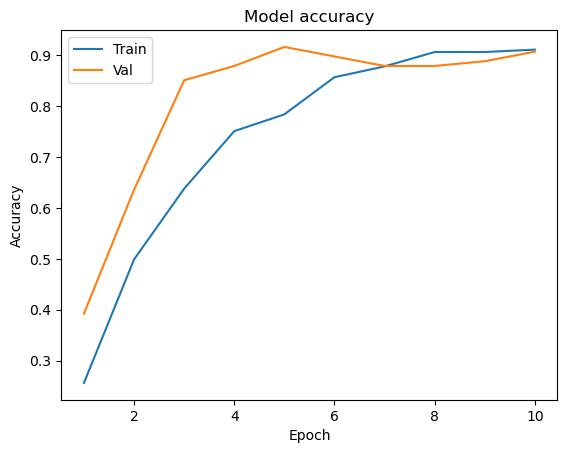

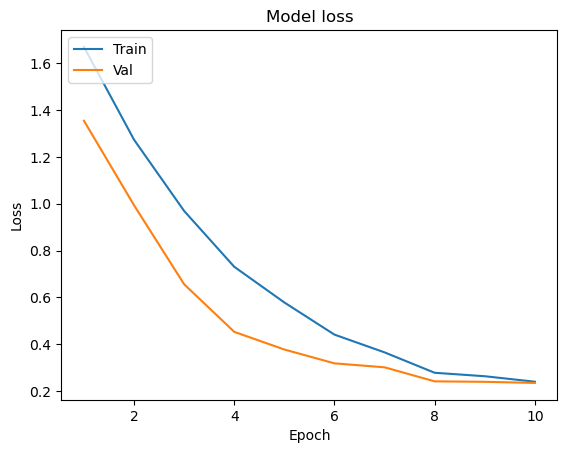

In [33]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
  
  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
     

plot_learningCurve(history, 10)

In [34]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
     

y_pred = np.argmax(model.predict(X_test), axis=-1)
     

y_pred

4/4 [==============================] - 0s 6ms/step


array([4, 2, 2, 1, 1, 1, 5, 4, 2, 4, 3, 2, 0, 2, 3, 2, 1, 1, 2, 5, 0, 5,
       5, 1, 1, 0, 5, 3, 3, 1, 0, 0, 4, 5, 2, 5, 2, 1, 1, 2, 2, 5, 4, 0,
       4, 4, 2, 3, 3, 3, 2, 4, 5, 4, 0, 3, 3, 4, 3, 4, 0, 1, 1, 4, 1, 2,
       1, 0, 3, 3, 3, 5, 4, 4, 4, 0, 5, 2, 3, 5, 4, 3, 3, 4, 4, 3, 0, 3,
       5, 5, 5, 0, 2, 1, 0, 0, 3, 0, 0, 1, 2, 5, 0, 5, 1, 0, 2],
      dtype=int64)

(<Figure size 700x700 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

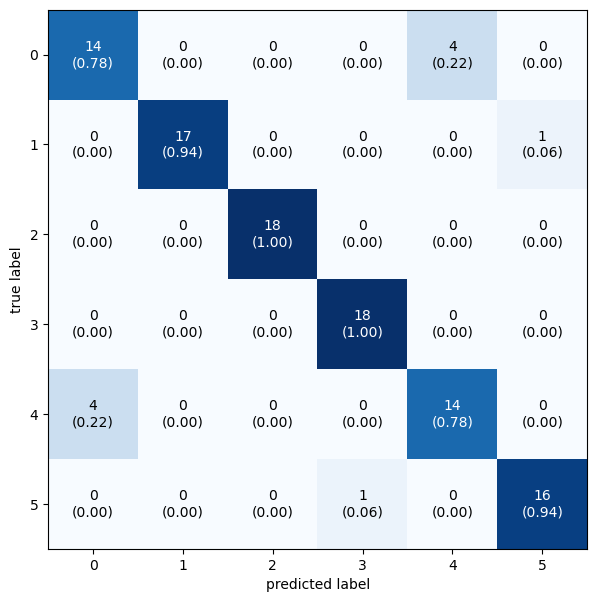

In [35]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, show_normed=True, figsize=(7,7))

In [ ]:
Concatenate()([gen, li])